# State Tomography
State tomography allows for analysis of the quantum state produced by a particular quantum process, through measurement of the density matrix of the state.

This notebook demonstrates utilisation of the StateTomography object, which can be used for generating the required experiments and processing the created data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lightworks as lw
from lightworks import emulator, qubit
from lightworks.tomography import StateTomography, density_from_state

Before starting, a general function is defined to quickly perform the plotting of density matrices. This takes a complex matrix and plots the real and imaginary parts separately.

In [2]:
def plot_density_matrix(rho: np.ndarray) -> tuple:
    """
    General function for plotting a density matrix. It will split up and plot
    the real and imaginary components using a common colorbar between them.
    """
    # Find plot range
    vmin = min(np.real(rho).min(), np.imag(rho).min())
    vmax = max(np.real(rho).max(), np.imag(rho).max())

    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(np.real(rho), vmin=vmin, vmax=vmax)
    ax[0].set_title("Re(\u03c1)")
    im = ax[1].imshow(np.imag(rho), vmin=vmin, vmax=vmax)
    ax[1].set_title("Im(\u03c1)")
    fig.colorbar(im, ax=ax.ravel().tolist())

    # Set ticks as integer values and create state labels
    ticks = range(rho.shape[0])
    n_qubits = int(np.log2(len(ticks)))
    basis = ["0", "1"]
    labels = list(basis)
    for _ in range(n_qubits - 1):
        labels = [q1 + q2 for q1 in labels for q2 in basis]
    for i in range(2):
        ax[i].set_xticks(ticks, labels=labels)
        ax[i].set_yticks(ticks, labels=labels)

    return (fig, ax)

## Single Qubit
First, single qubit states are examined, starting with $\ket{0}$. This is created by using an identity gate circuit and a photonic input state of $\ket{10}$. The circuit defined below acts as a base circuit to use with the StateTomography, which is then modified as part of the algorithm.

.. note::
    The input state is defined later on, when we run the experiments on a backend, as this is user-defined for state tomography (but not for process tomography).

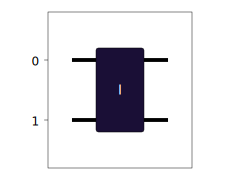

In [3]:
identity_circ = qubit.I()
identity_circ.display()

Then, we'll create the StateTomography object and use this to generate the required experiments.

In [4]:
n_qubits = 1

tomo = StateTomography(n_qubits, identity_circ)

experiments = tomo.get_experiments()

The data for the tomography can then be generated using the target backend. A list of the results is created, it is important that this matches the order of the experiments. 

In [5]:
backend = emulator.Backend("slos")

# Generate results and return
results = []
for circ in experiments.all_circuits:
    sampler = lw.Sampler(
        circ,
        lw.State([1, 0]),
        10000,
        random_seed=11,
    )
    results.append(backend.run(sampler))

The state tomography can then be ran on the results with the process method and the produced density matrix examined.

In [6]:
rho = tomo.process(results)

From below, the density matrix is approximately

$\begin{equation}\rho = \begin{bmatrix} 1 & 0\\ 0 & 0 \end{bmatrix}\end{equation}$

which is as expected using the equation

$\begin{equation}\rho = \ket{\Psi}\bra{\Psi} = \ket{0}\bra{0} \end{equation}$

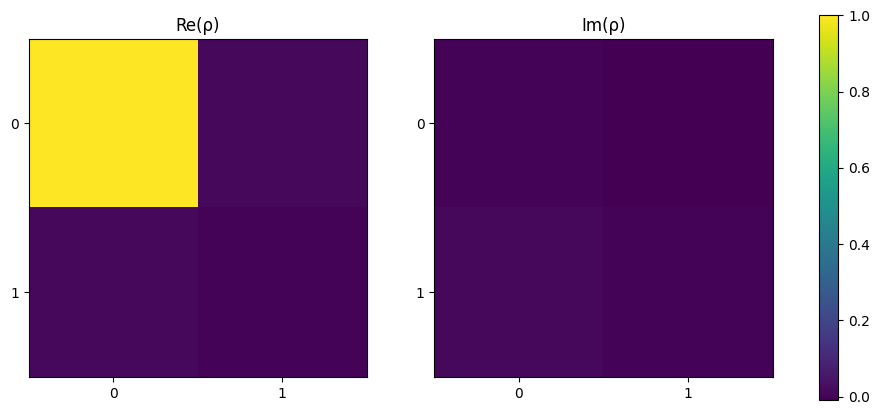

In [7]:
plot_density_matrix(rho)
plt.show()

### $\ket{+}$ tomography
Next we can perform tomography of the $\ket{+}$ state, through creation of this with a hadamard gate. This is the case as the experiment_1q function uses the input $\ket{0}$.

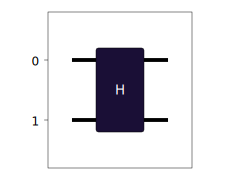

In [8]:
h_circ = qubit.H()
h_circ.display()

A new set of experiments is first generated with the tomography object.

In [9]:
n_qubits = 1

tomo = StateTomography(n_qubits, h_circ)

experiments = tomo.get_experiments()

The results are then created for these experiments. In this case, we choose to store the data as a dictionary instead of a list, with the measurement basis as keys. This is useful in cases where for some reason the order of results may not be well preserved.

In [10]:
backend = emulator.Backend("slos")

# Generate results and return
results = {}
for exp in experiments:
    sampler = lw.Sampler(
        exp.circuit,
        lw.State([1, 0]),
        10000,
        random_seed=11,
    )
    results[exp.measurement_basis] = backend.run(sampler)

rho = tomo.process(results)

Again the density matrix is as expected using:

$\begin{equation}\rho = \ket{+}\bra{+} = \frac{1}{2} (\ket{0}\bra{0} + \ket{0}\bra{1} + \ket{1}\bra{0} + \ket{1}\bra{1}) \end{equation}$

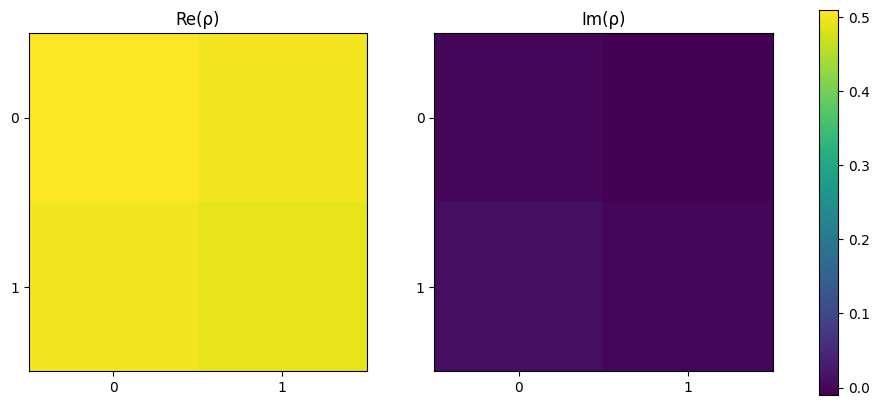

In [11]:
plot_density_matrix(rho)
plt.show()

## Two Qubit
StateTomography also supports multi-qubit states. Below, a circuit to create a bell state is defined using a hadamard and CNOT gate. This will produce the output $\ket{\Phi^+} = \frac{1}{\sqrt{2}}(\ket{00} + \ket{11})$.

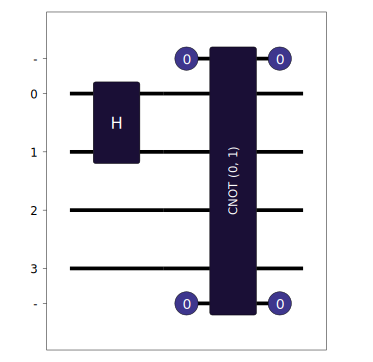

In [12]:
n_qubits = 2

bell_circuit = lw.PhotonicCircuit(2 * n_qubits)
bell_circuit.add(qubit.H())
bell_circuit.add(qubit.CNOT())

bell_circuit.display()

When running multiple tomography experiments, it may be useful to have a function which contains the majority of the logic for creating the data. An example of this is shown below, where we parametrize the number of qubits, source & target backend for flexibility. 

In [13]:
def run_experiments(experiments, n_qubits, source, backend) -> list:
    """
    Generalised version of experiment function, designed for any
    number of qubits. It is assumes the provided circuits contain dual-rail
    encoded qubits across pairs of adjacent modes.
    """
    # Post-select on 1 photon across each pair of qubit modes
    post_select = lw.PostSelection()
    for i in range(n_qubits):
        post_select.add((2 * i, 2 * i + 1), 1)

    # Generate results and return
    results = []
    for circ in experiments.all_circuits:
        sampler = lw.Sampler(
            circ,
            lw.State([1, 0] * n_qubits),
            1000,
            source=source,
            post_selection=post_select,
            random_seed=21,
        )
        results.append(backend.run(sampler))
    return results

As before, the experiments are then generated for this particular circuit.

In [14]:
tomo = StateTomography(n_qubits, bell_circuit)
experiments = tomo.get_experiments()

For this tomography, we'll create an ideal source and choose the emulator 'slos' backend.

In [15]:
source = emulator.Source()
backend = emulator.Backend("slos")

This data is then passed to the run experiments function and the density matrix calculated with the results.

In [16]:
results = run_experiments(experiments, n_qubits, source, backend)
rho = tomo.process(results)

Again, this density matrix matches that which would be expected with $\rho = \ket{\Phi^+}\bra{\Phi^+}$.

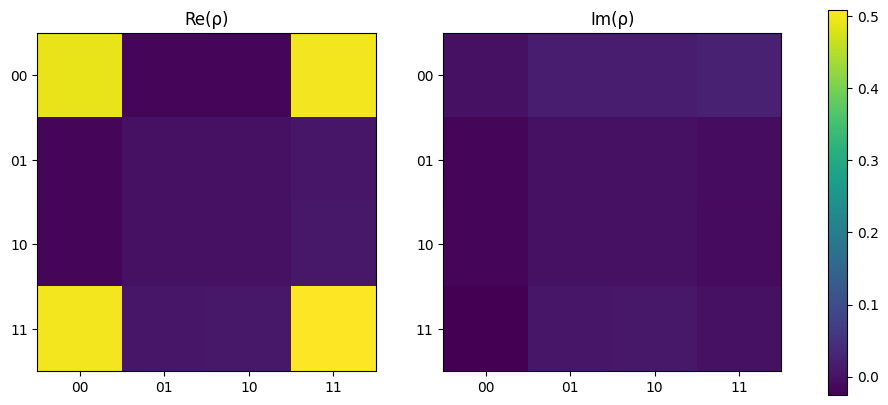

In [17]:
plot_density_matrix(rho)
plt.show()

After calculation, it is also possible to calculate the fidelity with respect to the expected matrix using the fidelity method. The tomography module contains a density_from_state function which enables the density matrix to be calculated from the expected state.

No imperfections were included within the system, so as expected the fidelity is 100%.

In [18]:
rho_exp = density_from_state([2**-0.5, 0, 0, 2**-0.5])

print(f"Fidelity = {tomo.fidelity(rho_exp) * 100:.2f} %")

Fidelity = 100.00 %


### Imperfect SPS
It is also possible to include the error sources from the emulator to view how these change fidelity. Below, the single photon source is modified to have indistinguishability of 95% and purity of 99%.

In [19]:
source.indistinguishability = 0.9
source.purity = 0.9

When re-running the state tomography, it can be seen how the denisty matrix begins to vary from ideal and the fidelity drops to ~93%.

Fidelity = 85.75 %


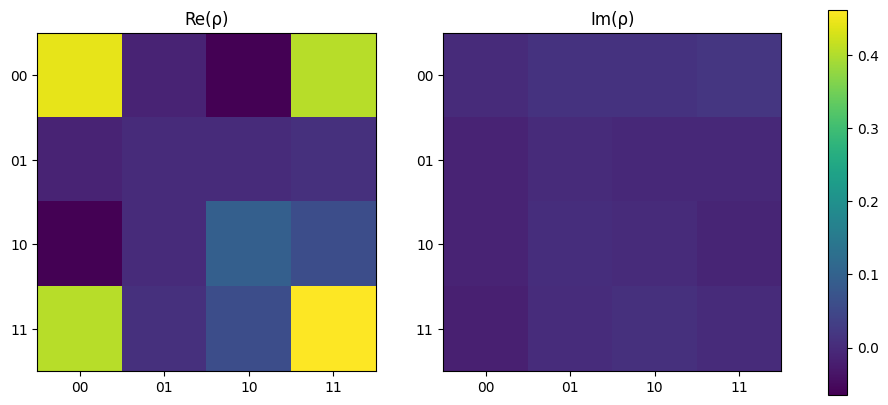

In [20]:
results = run_experiments(experiments, n_qubits, source, backend)
rho = tomo.process(results)

print(f"Fidelity = {tomo.fidelity(rho_exp) * 100:.2f} %")

plot_density_matrix(rho)
plt.show()

## Projection to a physical process
For a calculated density matrix to be physical, it should have the following properties:
1. It is Hermitian.
2. $\text{Tr}(\rho)$ = 1.
3. All eigenvalues are non-negative.

However, it is possible for tomography methods to produce unphysical matrices, particularly in the presence of noise or low shot numbers. Above, we have intentionally introduced low source performance and used a low number of samples, and when we then view the eigenvalues of the calculated density matrix with `check_eigenvalues` it can be seen that the first one is negative.

In [21]:
tomo.check_eigenvalues()

array([-0.02672052,  0.00636689,  0.16176132,  0.85859231])

To correct this, the `project_to_physical` option is added when calculating the density matrix, which will add an additional post-processing step to ensure the matrix is physical.

.. note::
    There are many different options to project a density matrix to be physical and Lightworks implements just one of these, in particular <cite data-cite="smolin2012">(smolin2012)</cite> is chosen. For certain applications you may find more success with other alternatives.

In [22]:
rho = tomo.process(results, project_to_physical=True)

If we then re-calculate the eigenvalues it can be seen that while once is still technically negative, it is essentially zero, and as such the projection procedure has been successful.

In [23]:
tomo.check_eigenvalues()

array([-2.83385910e-16,  1.04709392e-16,  1.51584505e-01,  8.48415495e-01])

The fidelity and updated density matrix can then be viewed. In this case a small drop in the fidelity compared to the expected matrix is seen.

Fidelity = 84.73 %


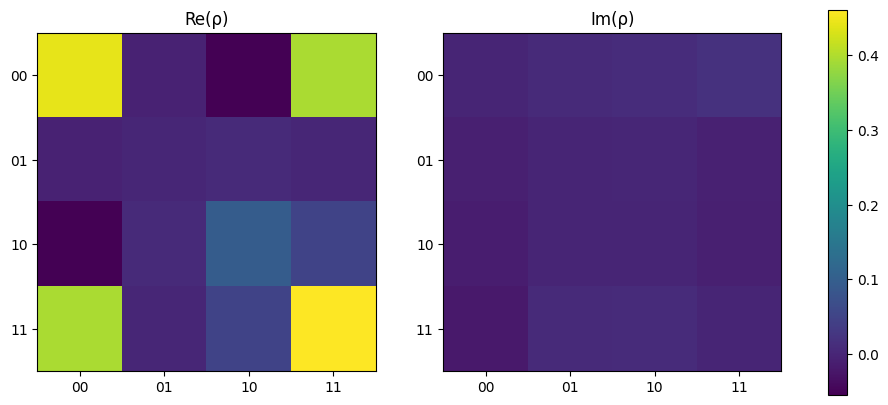

In [24]:
print(f"Fidelity = {tomo.fidelity(rho_exp) * 100:.2f} %")

plot_density_matrix(rho)
plt.show()